In [1]:
from pathlib import Path
from caiman import load_memmap
from ipywidgets import IntSlider, interact
import pandas as pd
from mesmerize_napari.core import CaimanDataFrameExtensions, CaimanSeriesExtensions, \
    CNMFExtensions, MCorrExtensions, set_parent_data_path, get_parent_data_path

In [2]:
# load the batch dataframe
sess_name = '121819_IT'
cnmf_df = pd.read_pickle('/home/kushal/rotations/hantman/hdf5s_march15/JoyJ2/batch/batch_cnmf.pickle')
cnmf_df = cnmf_df[cnmf_df['name'].str.startswith(sess_name)]
cnmf_df

,algo,name,input_movie_path,params,outputs,uuid
0,cnmf,121819_IT-m1,JoyJ2/121819_IT/7dd6588e-d4c1-4363-a8e0-35141f...,"{'refit': True, 'cnmf_kwargs': {'p': 2, 'nb': ...",{'cnmf-hdf5-path': JoyJ2/121819_IT/4d72d32a-1e...,4d72d32a-1e55-4898-858e-1c7fd4cad0dc
1,cnmf,121819_IT-ppc,JoyJ2/121819_IT/c1c266b4-405f-4c9d-a8c6-30697b...,"{'refit': True, 'cnmf_kwargs': {'p': 2, 'nb': ...",{'cnmf-hdf5-path': JoyJ2/121819_IT/4b92e5dc-4c...,4b92e5dc-4ca0-4074-9b76-47a635dfdc89
2,cnmf,121819_IT-rfa,JoyJ2/121819_IT/0bc5f56d-57a5-4a79-8f15-3710c9...,"{'refit': True, 'cnmf_kwargs': {'p': 2, 'nb': ...",{'cnmf-hdf5-path': JoyJ2/121819_IT/0a336f84-02...,0a336f84-021a-432a-9727-db652cdae577
3,cnmf,121819_IT-s1,JoyJ2/121819_IT/3ba0c3fd-7f3c-4231-bbe9-4cd7e7...,"{'refit': True, 'cnmf_kwargs': {'p': 2, 'nb': ...",{'cnmf-hdf5-path': JoyJ2/121819_IT/51a4abfd-40...,51a4abfd-4006-4a16-b837-d20cec275661


In [3]:
set_parent_data_path('/home/kushal/rotations/hantman')

PosixPath('/home/kushal/rotations/hantman')

RFBOutputContext()


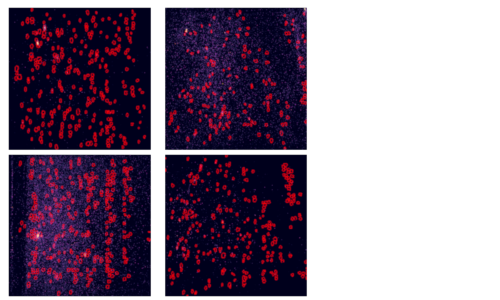

JupyterWgpuCanvas()

In [4]:
import numpy as np
import imageio
import pygfx as gfx

# auto-import the right canvas, if on jupyter or on desktop
from wgpu.gui.auto import WgpuCanvas
from time import time

# Create a canvas, scene, and rederer
canvas = WgpuCanvas()
renderer = gfx.renderers.WgpuRenderer(canvas)
scene = gfx.Scene()

# num of vids and dims of frames
n_videos = 4
dims = (512, 512)

camera = gfx.OrthographicCamera(1800, 550)
camera.position.y = 512
camera.scale.y = -1
camera.position.x = 1736 / 2

colormap1 = gfx.cm.inferno

memmaped_images = list()


# Create an Image WorldObject
# Create a geometry & set the texture as the first frame
def create_first_frame(memmap):
    return gfx.Image(
        gfx.Geometry(grid=gfx.Texture(memmap[0].astype(np.float32).T, dim=2)),
        gfx.ImageBasicMaterial(clim=(3000, 6000), map=colormap1),
    )


images = list()
img_pos = 0


# Add the first frame of all vids to the scene
for i, r in cnmf_df.iterrows():
    memmaped_images.append(r.cnmf.get_input_memmap())
    images.append(create_first_frame(memmaped_images[-1]))
    
    images[-1].position.x = i % 2 * (50 + 512)
    
    if i > 1:
        images[-1].position.y = 512 + 16
        
    cnmf_obj = cnmf_df.iloc[i].cnmf.get_output()
    idx_components = cnmf_obj.estimates.idx_components
    roi_coors = cnmf_df.iloc[i].cnmf.get_spatial_contour_coors(idx_components)
    
    # Add the ROIs
    for rcs in roi_coors:
        colors = [np.array([1, 0, 0, 1])] * rcs.shape[0]
        
        rcs_z = np.zeros((rcs.shape[0], 3), dtype=np.float32)
        rcs[:, 0] += images[-1].position.x
        rcs[:, 1] += images[-1].position.y
        rcs_z[:, :-1] = rcs.astype(np.float32)
        rcs_z
        
        
        geometry = gfx.Geometry(positions=rcs_z, colors=colors)
        material = gfx.LineThinMaterial(thickness=4.0, vertex_colors=True)
        line = gfx.Line(geometry, material)
        line.position.z = 1
        scene.add(line)


    scene.add(images[-1])

frame_time = list()

slider_ix = 0

# update the textures on the geometry with the frame according to the slider position
def update_img(obj):
    t1 = time()
    
    global slider_ix
    
    for img_ix, img in enumerate(images):
        img.geometry.grid = gfx.Texture(memmaped_images[img_ix][slider_ix].T, dim=2)
    
    global frame_time
    
    frame_time.append(time() - t1)


def animate():
    scene.traverse(update_img)
    renderer.render(scene, camera)
    canvas.request_draw()

canvas.request_draw(animate)

canvas

In [5]:
print(1 / np.mean(frame_time))

33225.177980613174


In [6]:
@interact
def slider_index_update(ix=(0, 4996, 1)):
    global slider_ix
    slider_ix = ix

interactive(children=(IntSlider(value=2498, description='ix', max=4996), Output()), _dom_classes=('widget-inte…